Import Libraries

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np 
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

Data Exploratory

In [19]:
data = pd.read_csv("/kaggle/input/restaurant-reviews/Restaurant Reviews.csv")
data = data[['Review','Liked']]

In [20]:
print(data)

print(data.shape)



                                                 Review  Liked
0                              Wow... Loved this place.    1.0
1                                    Crust is not good.    0.0
2             Not tasty and the texture was just nasty.    0.0
3     Stopped by during the late May bank holiday of...    1.0
4     The selection on the menu was great and so wer...    1.0
...                                                 ...    ...
2215  The staff was untrained and unfamiliar with th...    NaN
2216     The portions were skimpy and left us hungry. 0    NaN
2217  The restaurant had unclean restrooms and unple...    NaN
2218  The waiters were slow and forgetful with our o...    NaN
2219     The food was poorly cooked and tasted burnt. 0    NaN

[2220 rows x 2 columns]
(2220, 2)


# **DATA Cleansing**                            

In [21]:

data['Review'] = data['Review'].apply(lambda x: x.lower())
data['Review'] = data['Review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
# removes any characters that are not alphabets, digits, or whitespace from the 'Review' column. This step helps to clean the text by removing special characters or punctuation marks.

print(data[ data['Liked'] == 1].size)# prints the total number of elements in the DataFrame where the 'Liked' column has a value of 1 (indicating positive reviews).
print(data[ data['Liked'] == 0].size)#prints the total number of elements in the DataFrame where the 'Liked' column has a value of 0 (indicating negative reviews).
    
max_features = 300  #max no. of feature extracted
tokenizer = Tokenizer(num_words=max_features, split=' ')
# indexing of sentence &word
tokenizer.fit_on_texts(data['Review'].values)#generates  index of vocab (index,vocab)
X = tokenizer.texts_to_sequences(data['Review'].values)

# converts the text in the 'Review' column to sequences of integers based on the vocabulary index generated by the tokenizer (index)
X = pad_sequences(X)#ensure they have the same length.

2198
2036


In [22]:
from gensim.models import Word2Vec
import numpy as np
embedding_dim = 100  # Specify the dimensionality of the word vectors
# . Each word in the embedding matrix will be represented by a vector of length embedding_dim.
model_w2v = Word2Vec(sentences=data['Review'].values, vector_size=embedding_dim, window=5, min_count=1, sg=1)
word_vectors = model_w2v.wv#retrieves the word vectors from the trained Word2Vec model. The wv attribute provides access to the word vectors.
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the unknown words
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in word_vectors:# checks if the current word is present in the word vectors obtained from the Word2Vec model.
        embedding_matrix[index] = word_vectors[word]#the word vector of the current word to the corresponding row in the embedding matrix.

In [23]:
import keras
opt = keras.optimizers.Adam(learning_rate=0.001)

In [24]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 26, 100)           234900    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 26, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 315,502
Trainable params: 315,502
Non-trainable params: 0
_________________________________________________________________


Preprocessing Data (NLTK Text Data Cleaning)

In [25]:
Y = pd.get_dummies(data['Liked']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
# (1554, 26) indicates that the training dataset has 1554 samples with 26 features.

(1554, 26) (1554, 2)
(666, 26) (666, 2)


In [26]:
validation_size = len(X_test) // 2

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

In [27]:
batch_size = 128
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=50, batch_size=batch_size, verbose=2, validation_data=(X_validate, Y_validate), callbacks=[early_stopping])

Epoch 1/50
13/13 - 5s - loss: 0.6856 - accuracy: 0.5071 - val_loss: 0.6760 - val_accuracy: 0.4535 - 5s/epoch - 375ms/step
Epoch 2/50
13/13 - 1s - loss: 0.6488 - accuracy: 0.6802 - val_loss: 0.6072 - val_accuracy: 0.7027 - 907ms/epoch - 70ms/step
Epoch 3/50
13/13 - 1s - loss: 0.5451 - accuracy: 0.7349 - val_loss: 0.4878 - val_accuracy: 0.8228 - 890ms/epoch - 68ms/step
Epoch 4/50
13/13 - 1s - loss: 0.4185 - accuracy: 0.8301 - val_loss: 0.3859 - val_accuracy: 0.8468 - 1s/epoch - 87ms/step
Epoch 5/50
13/13 - 1s - loss: 0.3287 - accuracy: 0.8855 - val_loss: 0.3462 - val_accuracy: 0.8589 - 1s/epoch - 92ms/step
Epoch 6/50
13/13 - 1s - loss: 0.2702 - accuracy: 0.8996 - val_loss: 0.3412 - val_accuracy: 0.8589 - 901ms/epoch - 69ms/step
Epoch 7/50
13/13 - 1s - loss: 0.2420 - accuracy: 0.9125 - val_loss: 0.3286 - val_accuracy: 0.8679 - 897ms/epoch - 69ms/step
Epoch 8/50
13/13 - 1s - loss: 0.2121 - accuracy: 0.9202 - val_loss: 0.3342 - val_accuracy: 0.8619 - 950ms/epoch - 73ms/step
Epoch 9/50
13/13

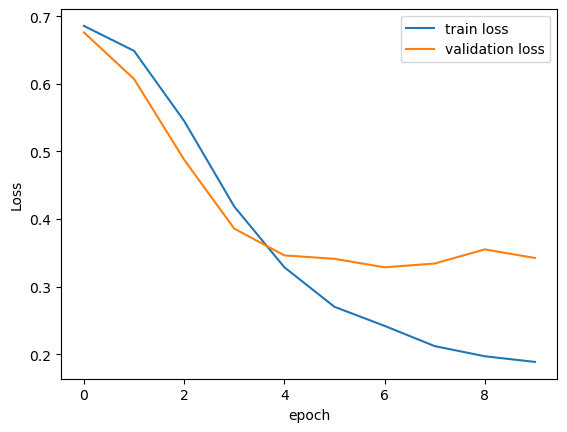

In [28]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

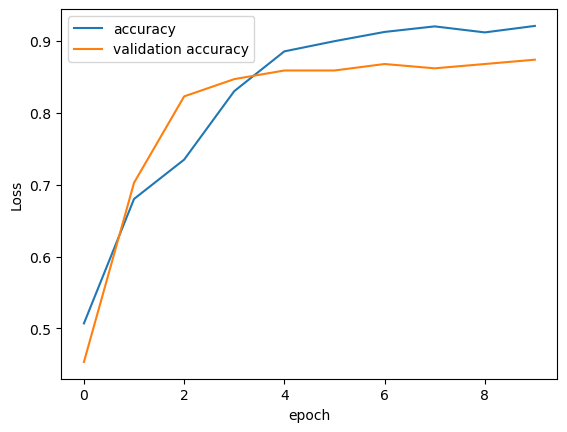

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [30]:
score, acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
print("score: %.2f" % score)
print("acc: %.2f" % acc)

3/3 - 0s - loss: 0.2640 - accuracy: 0.8799 - 60ms/epoch - 20ms/step
score: 0.26
acc: 0.88


In [31]:
# Calculate the predicted labels for the test data
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)  # Convert probabilities to class labels
Y_test = np.argmax(Y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1 score
report = classification_report(Y_test, Y_pred)
print("Classification Report:")
print(report)
# Precision: Precision measures the proportion of correctly predicted positive instances (true positives) out of all instances predicted as positive (true positives + false positives).
# Recall: Recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted positive instances (true positives) out of all actual positive instances (true positives + false negatives)
# F1-score: The F1-score is the harmonic mean of precision and recall.
# Support: Support represents the number of samples in each class, indicating the distribution of the classes in the test set.

11/11 [==============================] - 0s 8ms/step
Confusion Matrix:
[[159  15]
 [ 25 134]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       174
           1       0.90      0.84      0.87       159

    accuracy                           0.88       333
   macro avg       0.88      0.88      0.88       333
weighted avg       0.88      0.88      0.88       333



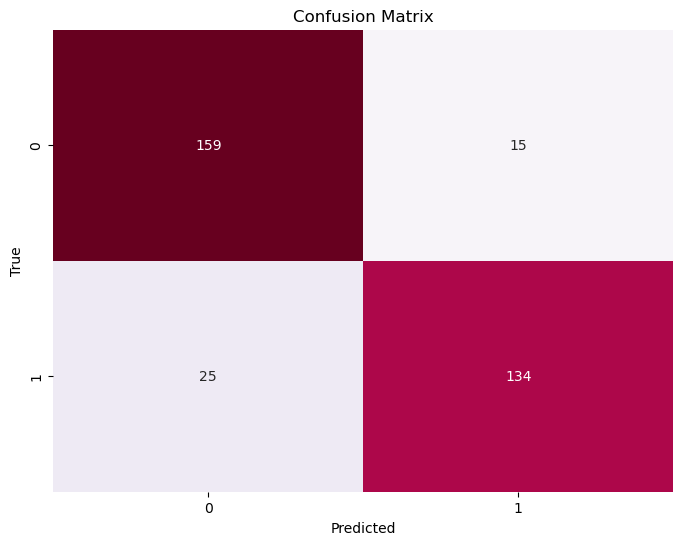

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="PuRd", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Steaming


In [33]:
text = ['the food is good']
#vectorizing the tweet by the pre-fitted tokenizer instance
texts = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
texts = pad_sequences(texts, maxlen=28, dtype='int32', value=0)
print(texts)
sentiment = model.predict(texts,batch_size=1,verbose = 2)[0]

print(f"Text: {text}")
print("Sentiment: ")
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   1  8 15 29]]
1/1 - 0s - 298ms/epoch - 298ms/step
Text: ['the food is good']
Sentiment: 
positive


In [34]:
text = ['the food is very bad']
#vectorizing the tweet by the pre-fitted tokenizer instance
texts = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
texts = pad_sequences(texts, maxlen=28, dtype='int32', value=0)
print(texts)
sentiment = model.predict(texts,batch_size=1,verbose = 2)[0]

print(f"Text: {text}")
print("Sentiment: ")
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1   8  15  35 172]]
1/1 - 0s - 23ms/epoch - 23ms/step
Text: ['the food is very bad']
Sentiment: 
negative


In [35]:
text = ['both the food and drink were fantastic.']
#vectorizing the tweet by the pre-fitted tokenizer instance
texts = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
texts = pad_sequences(texts, maxlen=28, dtype='int32', value=0)
print(texts)
sentiment = model.predict(texts,batch_size=1,verbose = 2)[0]

print(f"Text: {text}")
print("Sentiment: ")
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1   8   2   7 248]]
1/1 - 0s - 23ms/epoch - 23ms/step
Text: ['both the food and drink were fantastic.']
Sentiment: 
positive


In [36]:
text = ['The worst food I have ever eaten!']
#vectorizing the tweet by the pre-fitted tokenizer instance
texts = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
texts = pad_sequences(texts, maxlen=28, dtype='int32', value=0)
print(texts)
sentiment = model.predict(texts,batch_size=1,verbose = 2)[0]

print(f"Text: {text}")
print("Sentiment: ")
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1 222   8   9  49 108]]
1/1 - 0s - 23ms/epoch - 23ms/step
Text: ['The worst food I have ever eaten!']
Sentiment: 
negative


In [37]:
text = ["both the fish and chicken were bad... :("]
#vectorizing the tweet by the pre-fitted tokenizer instance
texts = tokenizer.texts_to_sequences(text)
#padding the tweet to have exactly the same shape as `embedding_2` input
texts = pad_sequences(texts, maxlen=28, dtype='int32', value=0)
print(texts)
sentiment = model.predict(texts,batch_size=1,verbose = 2)[0]

print(f"Text: {text}")
print("Sentiment: ")
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1   2 190   7 172]]
1/1 - 0s - 24ms/epoch - 24ms/step
Text: ['both the fish and chicken were bad... :(']
Sentiment: 
negative
